In [205]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import os
from env_paths import *
import matplotlib.pyplot as plt

In [206]:
INPUT_COLS = ["t_ext", "h_ext", "t_C_cal","h_C_cal","t_L_cal","h_L_cal"]
MIN_MAX_COLS_VALUES = {"t_ext": (-50, 50), "h_ext": (0, 100), "t_C_cal": (-50, 50), 
                       "t_L_cal": (-50, 50), "h_C_cal": (0, 100), "h_L_cal": (0, 100)}

In [207]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (máximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

In [208]:
files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(CLASSIFIED_SENSOR_PATH + files[0])
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)

In [209]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA

In [210]:

# Instanciacion del modelo, creacion de capas y declaracion de las neuronas por capas y su funcion de activacion
inputs = layers.Input(shape=(6,1))
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(8)(x)
# x = layers.Dense(30, activation="sigmoid")(x)
outputs = layers.Dense(6)(x)

model = kr.Model(inputs=inputs, outputs=outputs)
es_callback = kr.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5)
model.compile(loss="mse", optimizer=kr.optimizers.Adam(learning_rate=learning_rate))
model.summary()

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_val = pd.DataFrame()
y_val = pd.DataFrame()

rolling_win = df.groupby(pd.Grouper(freq="96H", key="ts"))
val_data_input = [] #Conjunto de datos de dentrada de validacion para graficar tras entrenamiento junto a predicciones.
val_data_target = [] #Conjunto de datos de salida de validacion para graficar tras entrenamiento junto a predicciones. 

for _, group in rolling_win: 
    if(len(group) == 0):
        continue
    
    train_size = int(0.5  * int(group.shape[0]))

    # Creacion del conjunto de datos de entrenamiento (desde el inicio de la serie temporal hasta fraccion_entrenamiento * tamano_grupo)
    train = group[0 : train_size - 1]
    train = train[:-1] if len(train) % 2 != 0 else train
    input_size = int(len(train) * 0.5)

    # Separacion de los inputs y los targets: X_train son los inputs de la RNA y y_train los targets
    X_train_group = train[INPUT_COLS].iloc[:input_size]
    y_train_group = train[INPUT_COLS].iloc[input_size :]

    X_train = pd.concat([X_train_group, X_train])
    y_train = pd.concat([y_train_group, y_train])

    val = group[train_size:]
    val = val[:-1] if len(val) % 2 != 0 else val

    val_size = len(val)
    input_size = int(val_size * 0.5)

    X_val_group = val[INPUT_COLS].iloc[:input_size]
    y_val_group = val[INPUT_COLS].iloc[input_size : ]

    val_data_input.append(X_val_group)
    val_data_target.append(y_val_group)

    X_val = pd.concat([X_val_group, X_val])
    y_val = pd.concat([y_val_group, y_val])

# Entrenamiento de la RNA
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[es_callback], workers=10)


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 6, 1)]            0         
                                                                 
 gru_43 (GRU)                (None, 6, 128)            50304     
                                                                 
 gru_44 (GRU)                (None, 6, 64)             37248     
                                                                 
 gru_45 (GRU)                (None, 32)                9408      
                                                                 
 dense_18 (Dense)            (None, 6)                 198       
                                                                 
Total params: 97,158
Trainable params: 97,158
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
118/118 [==============================] -

In [211]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# predictions = model.predict(X_test)

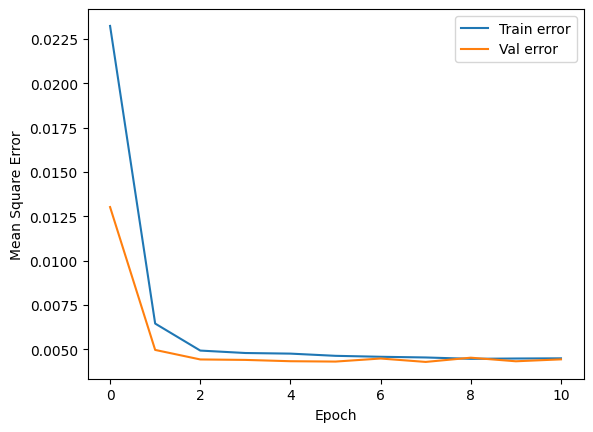

In [212]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

9/9 [==============================] - 1s 7ms/step


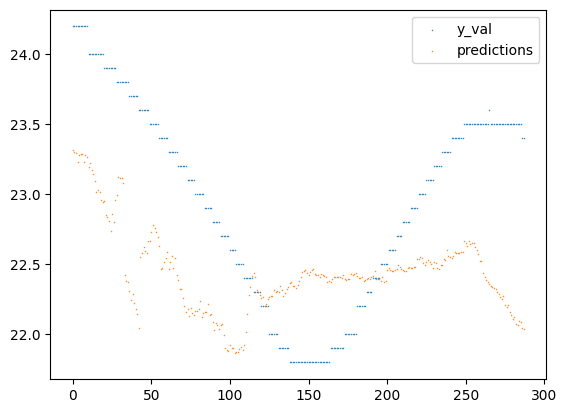

9/9 [==============================] - 1s 7ms/step


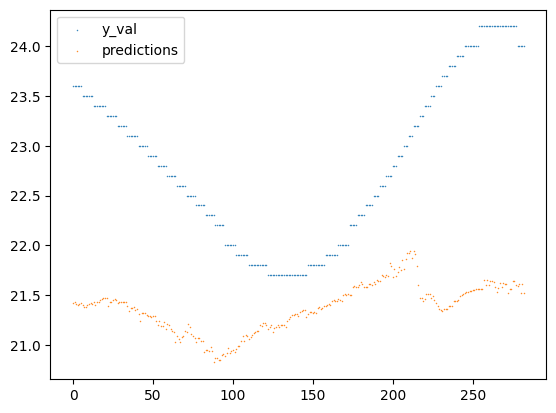

9/9 [==============================] - 0s 8ms/step


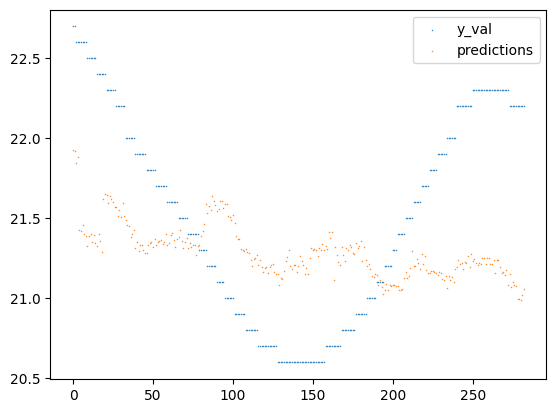

9/9 [==============================] - 0s 7ms/step


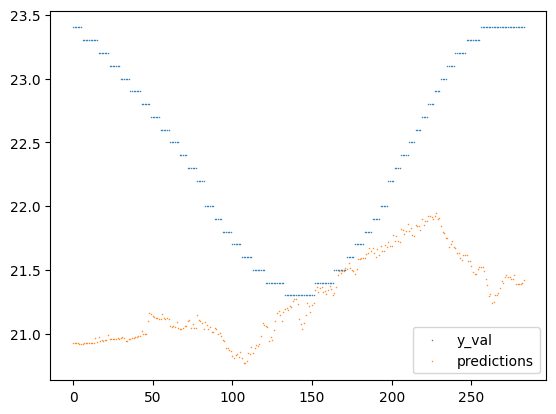

9/9 [==============================] - 0s 8ms/step


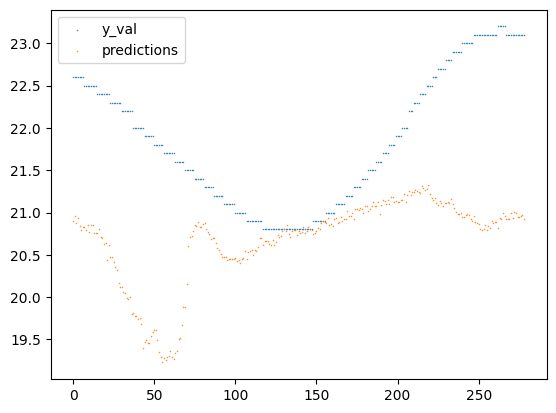

9/9 [==============================] - 0s 7ms/step


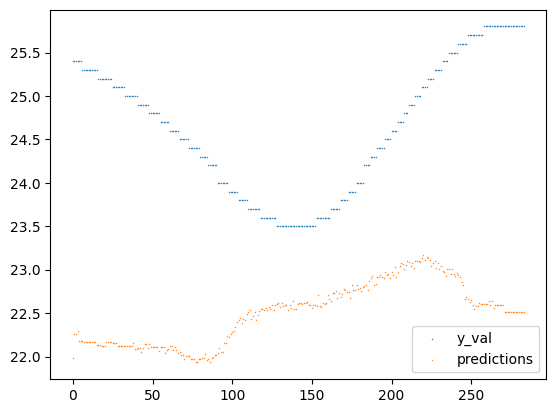

9/9 [==============================] - 0s 7ms/step


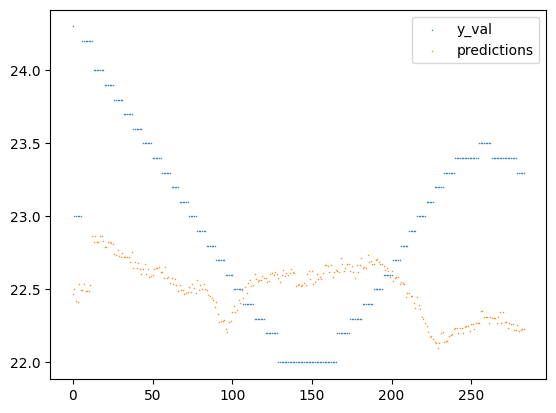

9/9 [==============================] - 0s 10ms/step


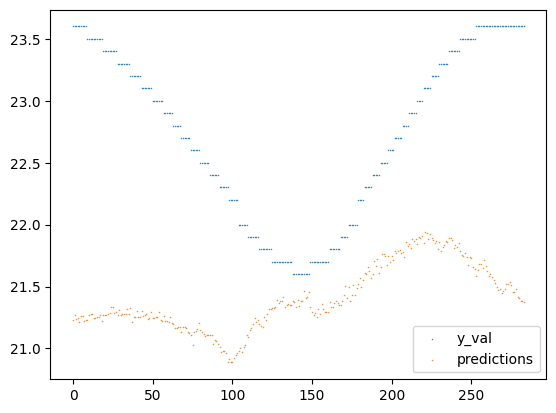

5/5 [==============================] - 0s 6ms/step


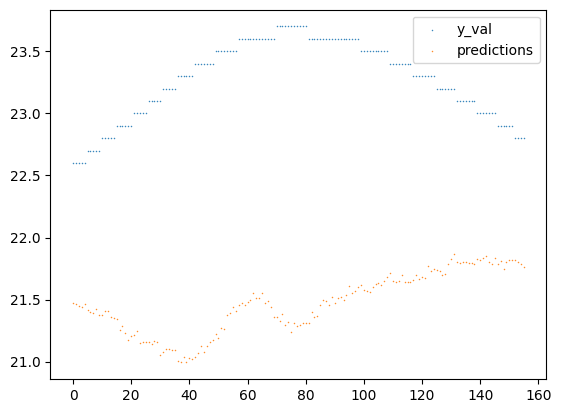

8/8 [==============================] - 0s 7ms/step


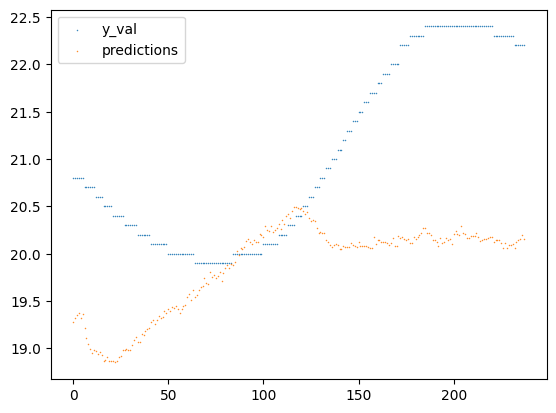

9/9 [==============================] - 0s 9ms/step


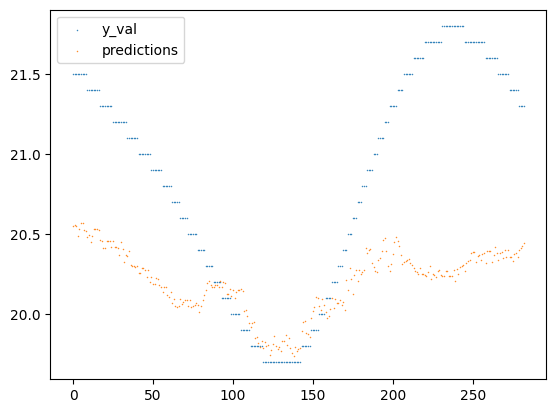

9/9 [==============================] - 0s 9ms/step


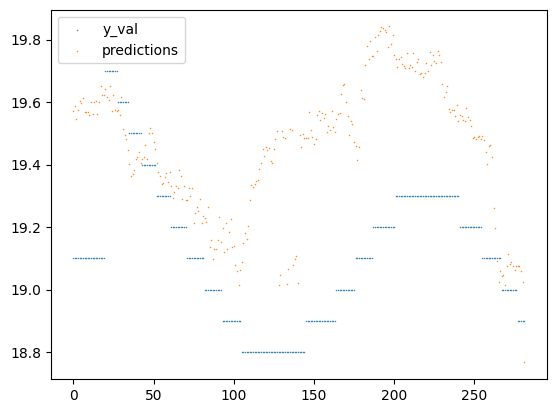

9/9 [==============================] - 0s 9ms/step


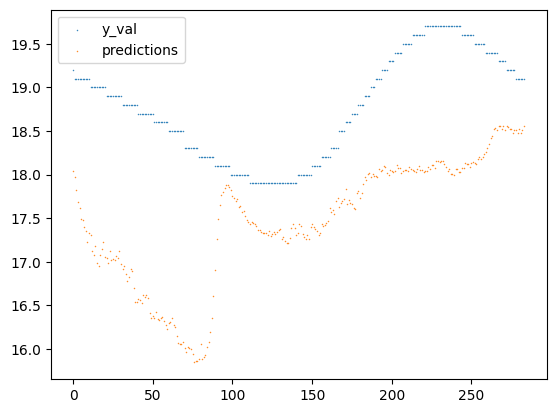

9/9 [==============================] - 0s 6ms/step


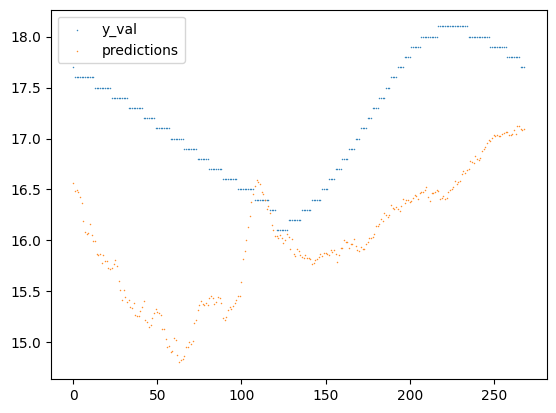

9/9 [==============================] - 0s 12ms/step


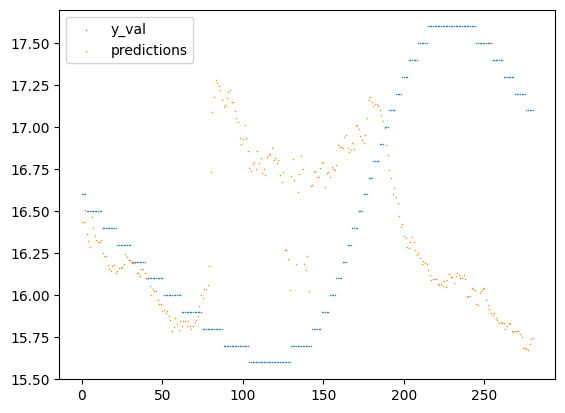

9/9 [==============================] - 0s 7ms/step


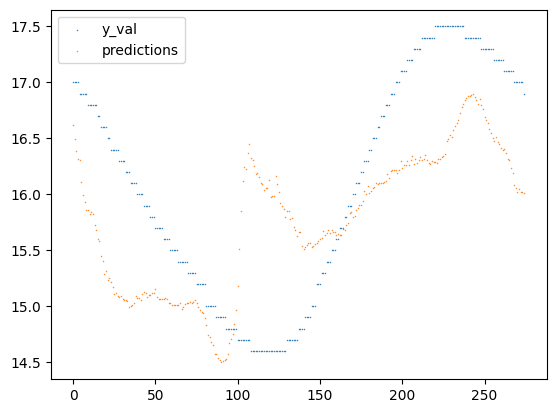

8/8 [==============================] - 0s 7ms/step


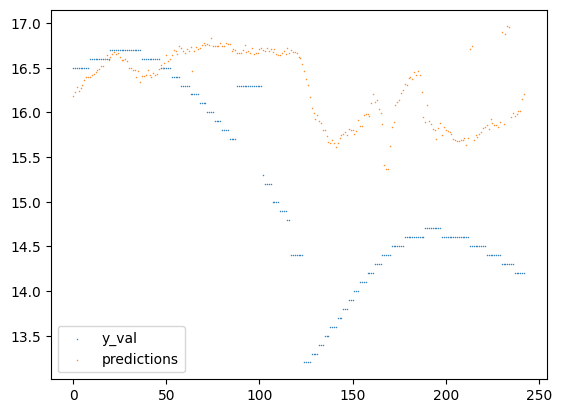

9/9 [==============================] - 0s 9ms/step


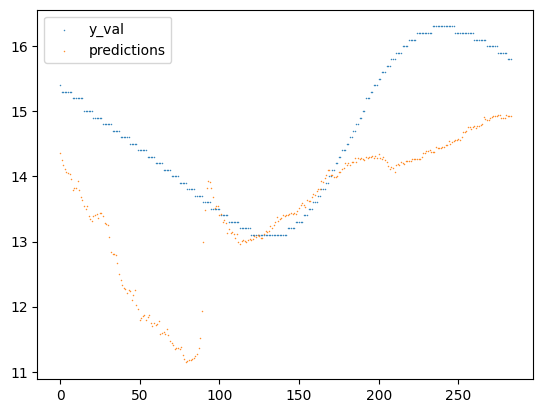

9/9 [==============================] - 0s 9ms/step


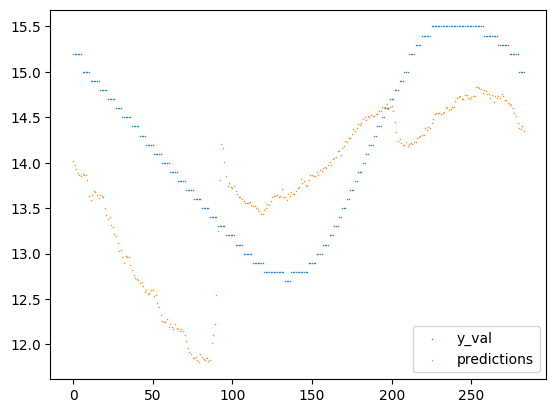

9/9 [==============================] - 0s 9ms/step


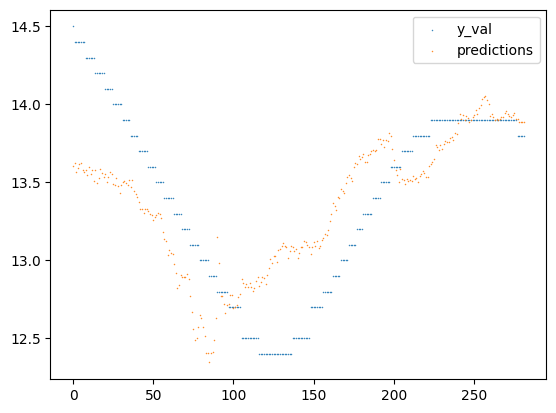

9/9 [==============================] - 0s 9ms/step


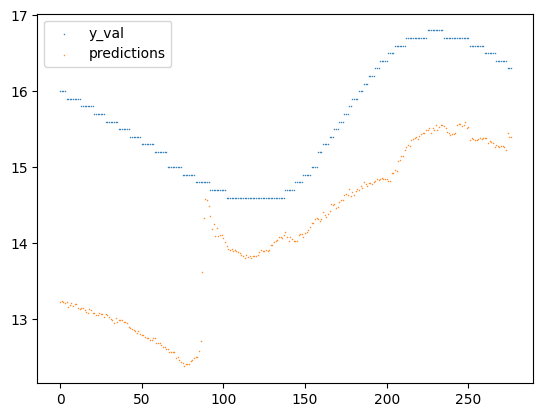

9/9 [==============================] - 0s 7ms/step


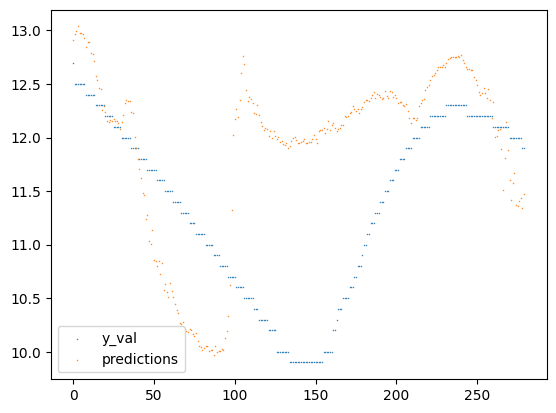

9/9 [==============================] - 0s 10ms/step


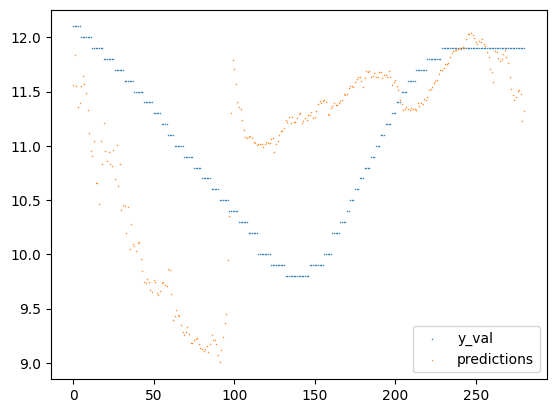

9/9 [==============================] - 0s 8ms/step


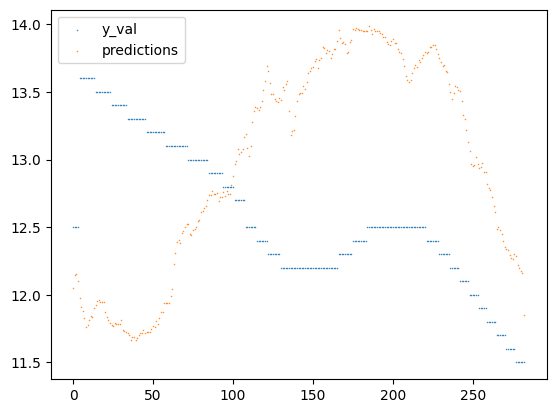

9/9 [==============================] - 0s 6ms/step


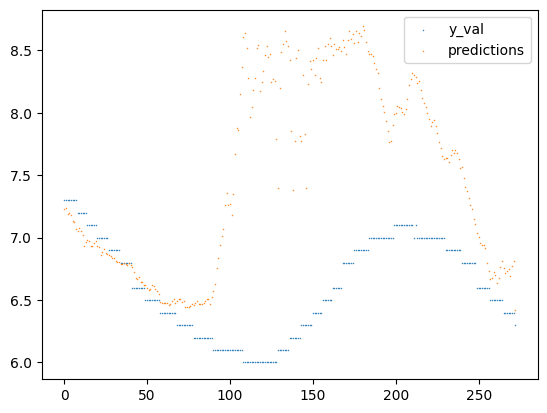

9/9 [==============================] - 0s 6ms/step


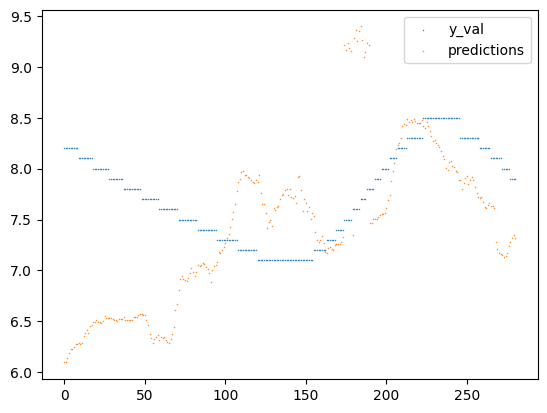

9/9 [==============================] - 0s 7ms/step


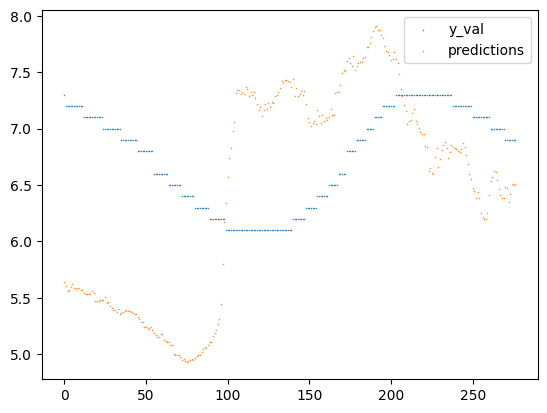

6/6 [==============================] - 0s 7ms/step


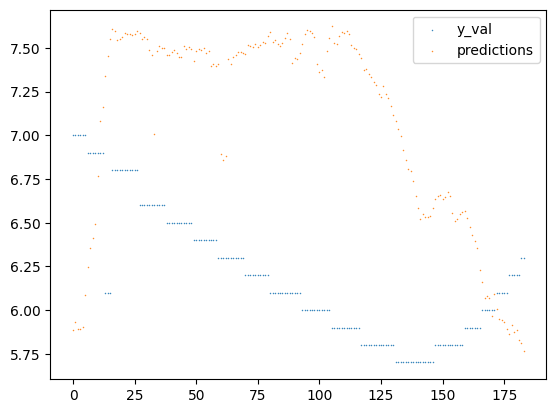

5/5 [==============================] - 0s 7ms/step


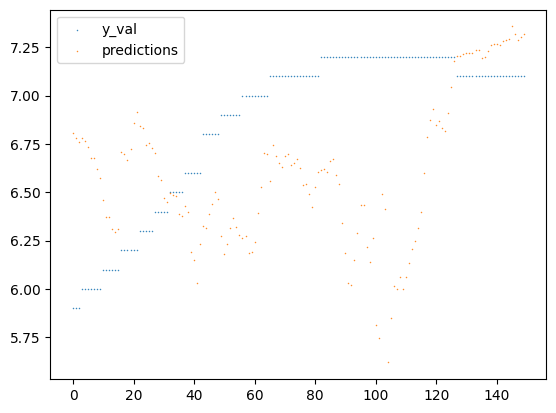

9/9 [==============================] - 0s 16ms/step


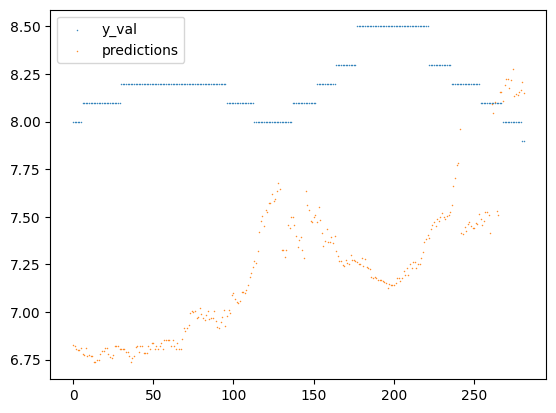

9/9 [==============================] - 0s 9ms/step


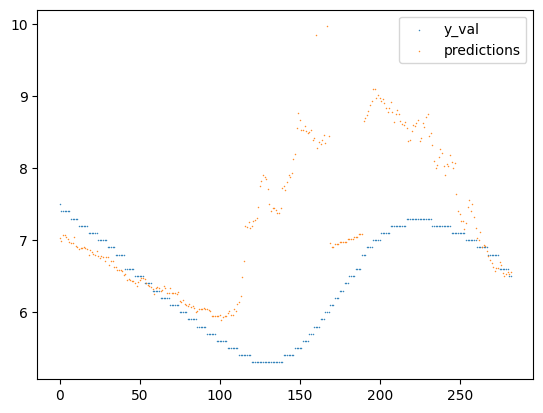

9/9 [==============================] - 0s 7ms/step


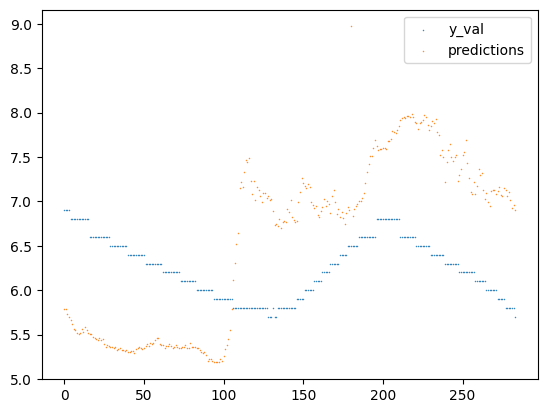

9/9 [==============================] - 0s 9ms/step


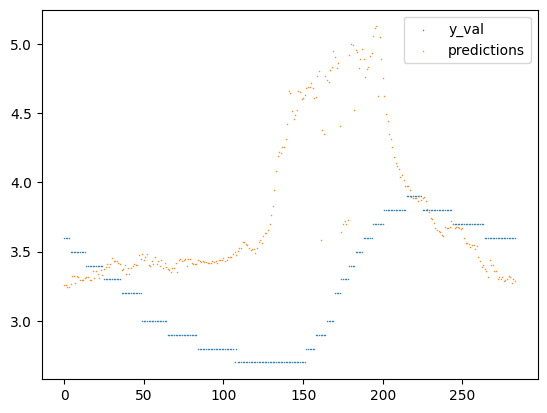

9/9 [==============================] - 0s 9ms/step


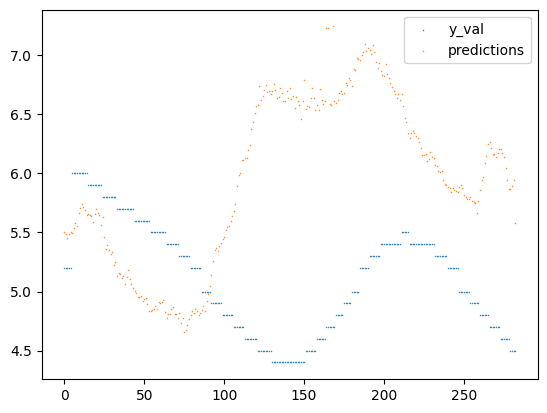

9/9 [==============================] - 0s 11ms/step


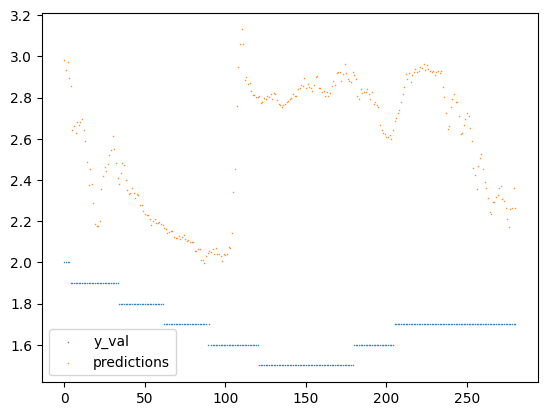

22/22 [==============================] - 0s 8ms/step


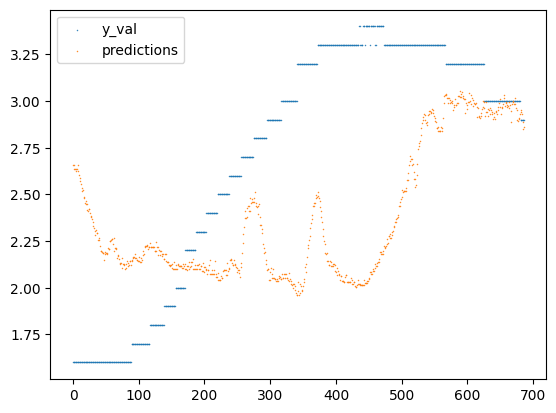

43/43 [==============================] - 0s 8ms/step


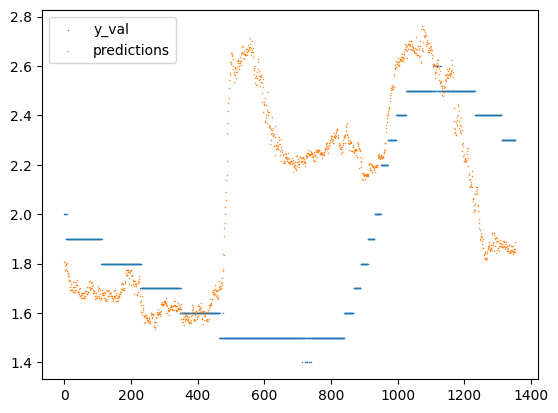

43/43 [==============================] - 0s 7ms/step


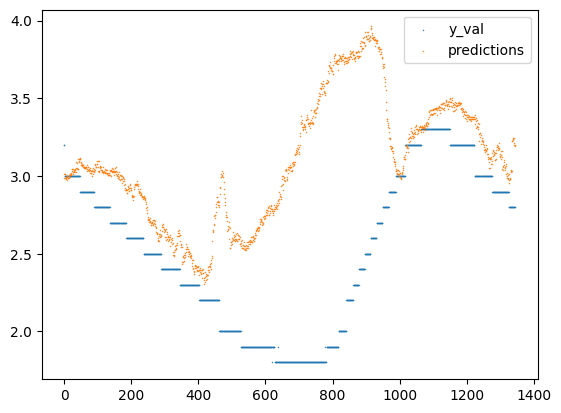

42/42 [==============================] - 0s 7ms/step


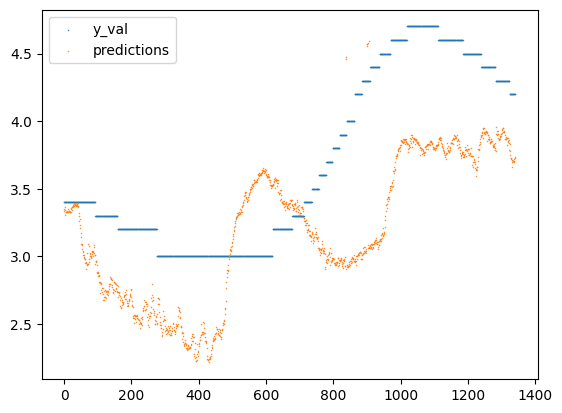

43/43 [==============================] - 0s 6ms/step


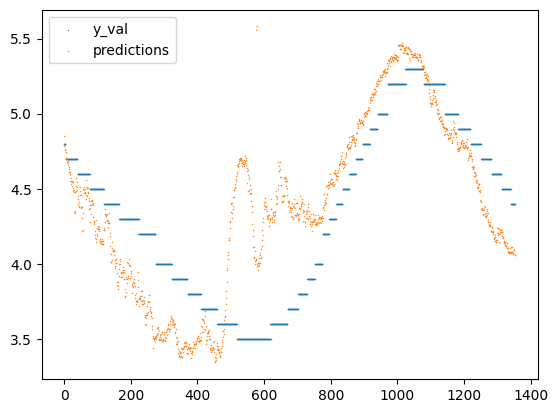

43/43 [==============================] - 0s 6ms/step


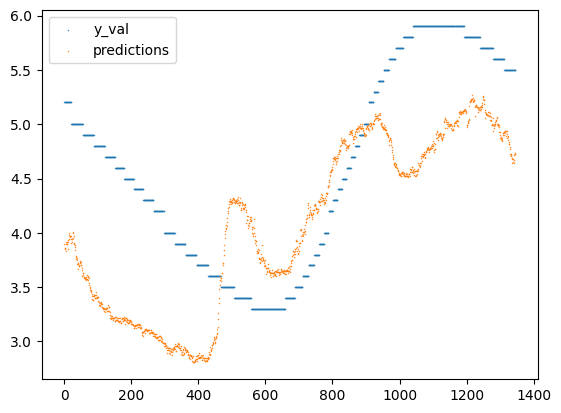

13/13 [==============================] - 0s 13ms/step


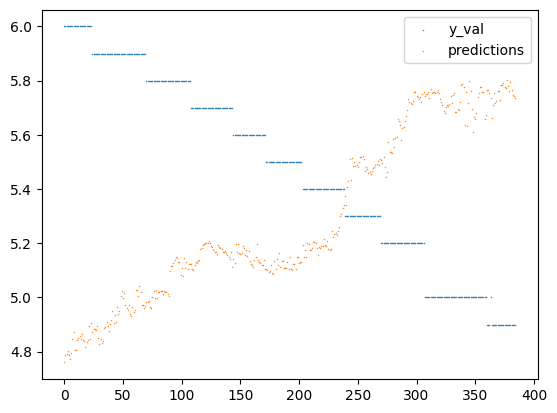

6/6 [==============================] - 0s 7ms/step


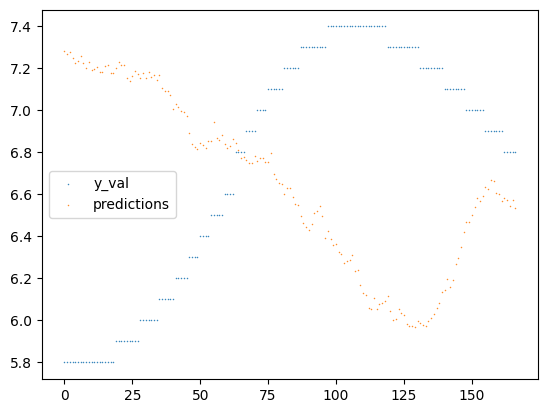

9/9 [==============================] - 0s 8ms/step


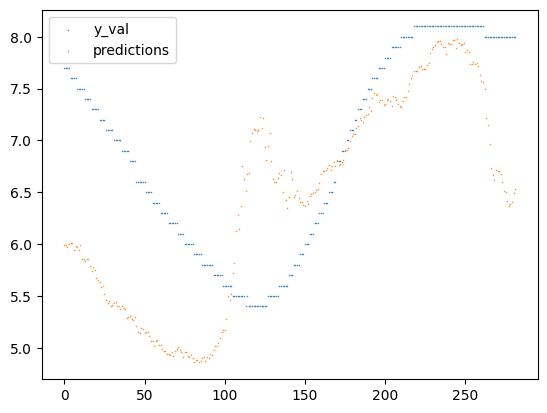

9/9 [==============================] - 0s 8ms/step


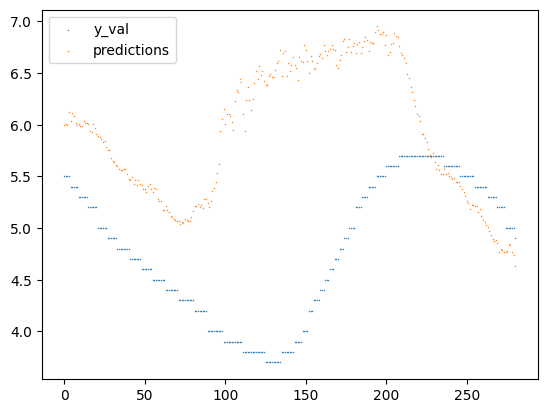

9/9 [==============================] - 0s 6ms/step


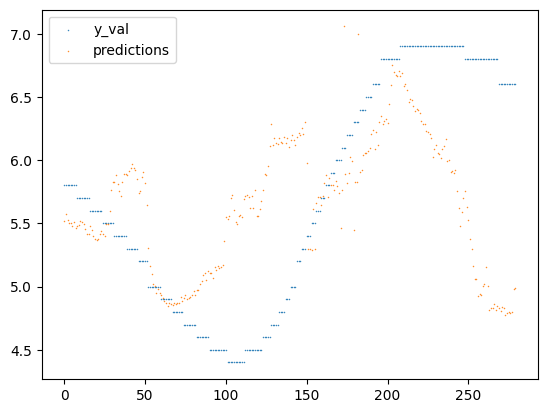

9/9 [==============================] - 0s 7ms/step


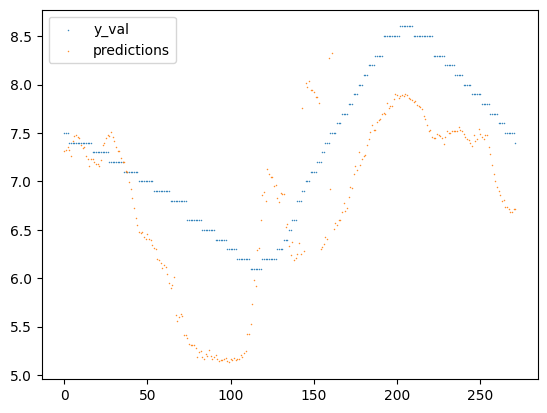

9/9 [==============================] - 0s 7ms/step


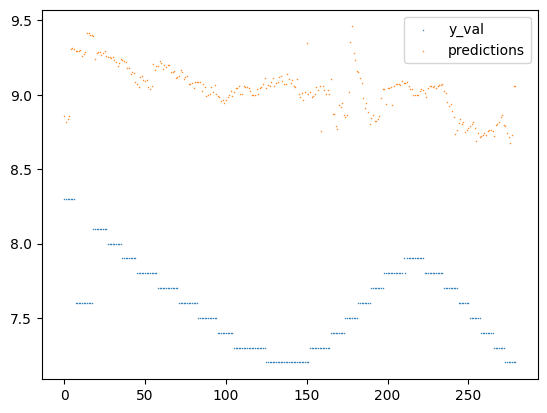

9/9 [==============================] - 0s 13ms/step


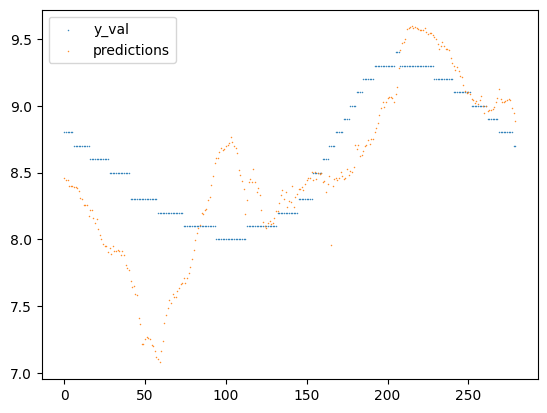

9/9 [==============================] - 0s 9ms/step


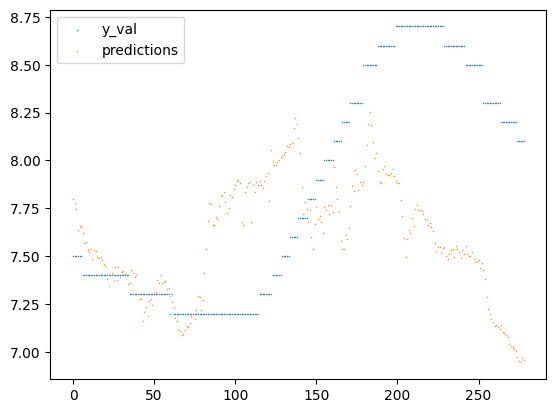

9/9 [==============================] - 0s 8ms/step


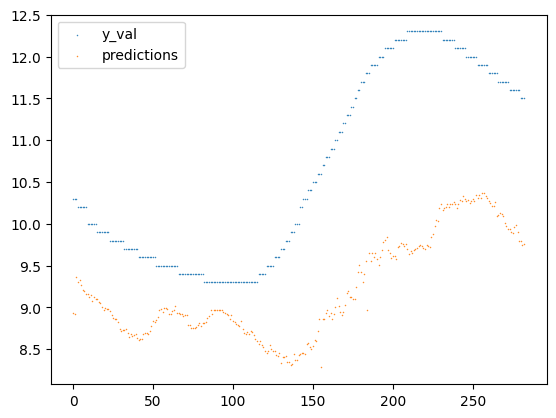

8/8 [==============================] - 0s 9ms/step


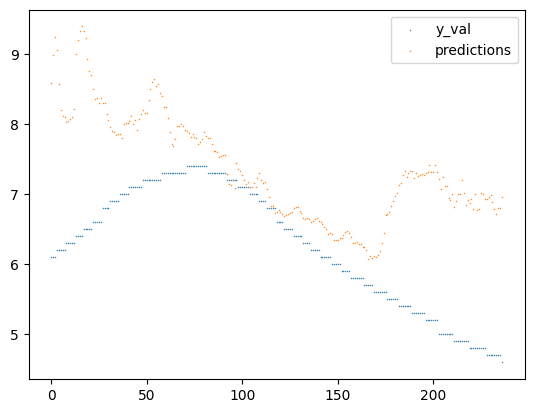

8/8 [==============================] - 0s 7ms/step


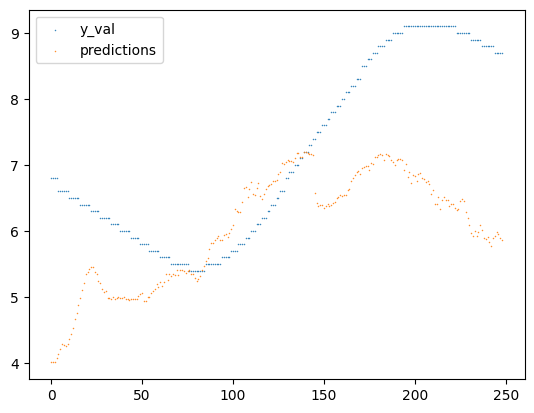

9/9 [==============================] - 0s 7ms/step


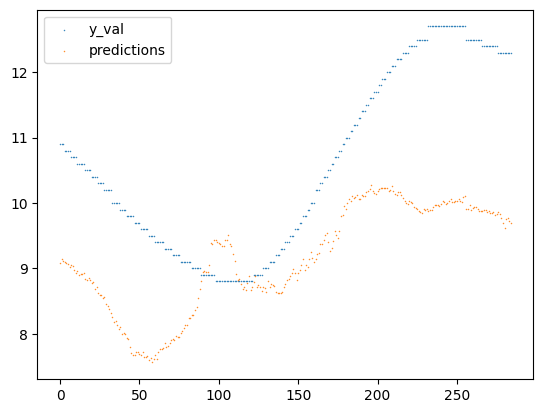

9/9 [==============================] - 0s 8ms/step


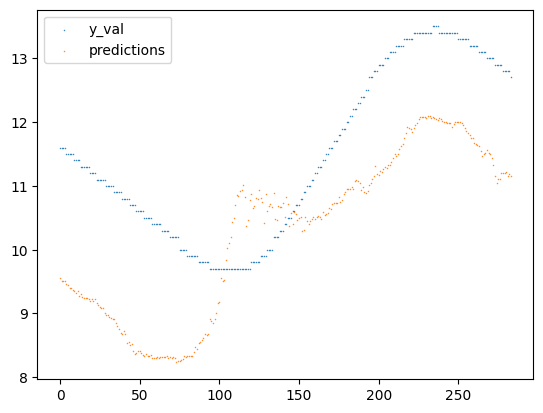

9/9 [==============================] - 0s 15ms/step


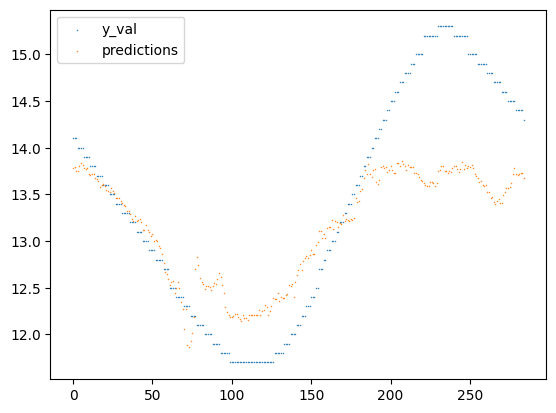

9/9 [==============================] - 0s 8ms/step


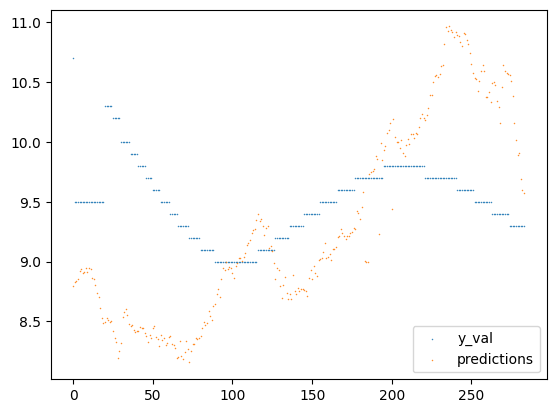

9/9 [==============================] - 0s 8ms/step


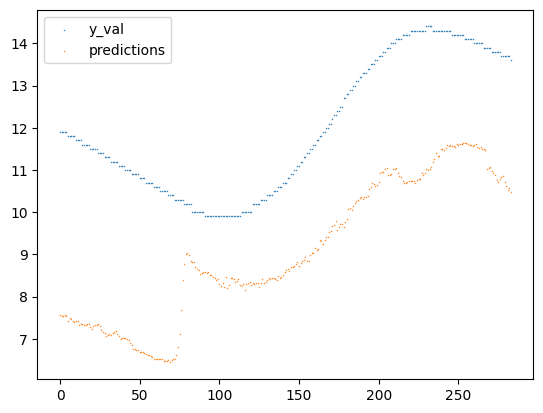

9/9 [==============================] - 0s 11ms/step


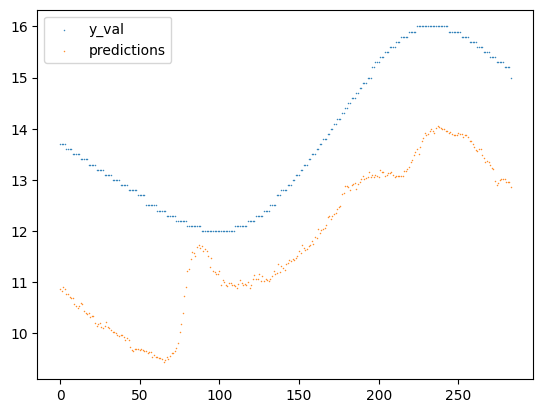

9/9 [==============================] - 0s 12ms/step


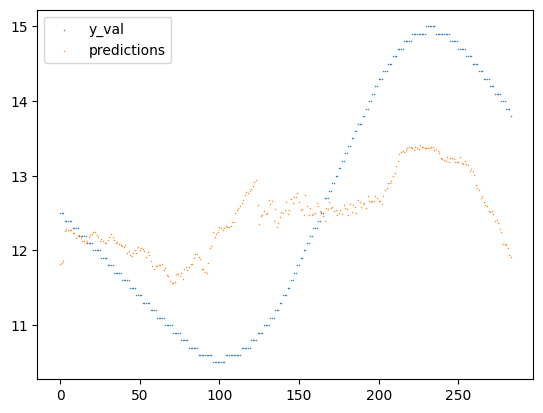

9/9 [==============================] - 0s 9ms/step


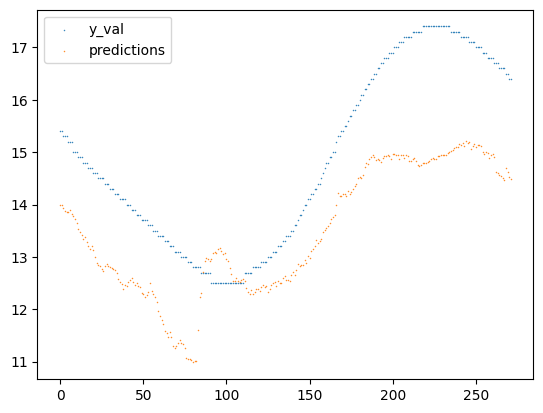

9/9 [==============================] - 0s 15ms/step


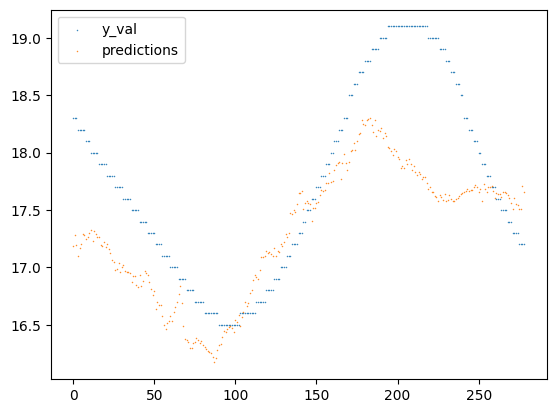

9/9 [==============================] - 0s 9ms/step


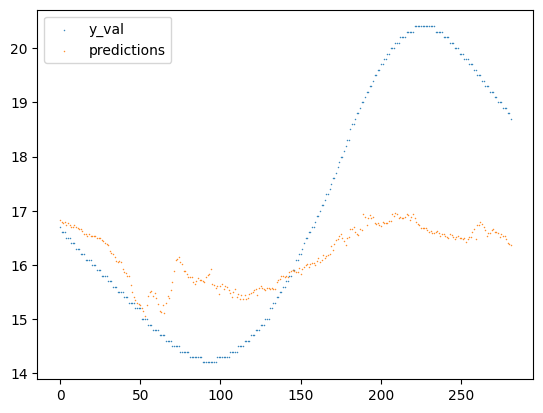

9/9 [==============================] - 0s 10ms/step


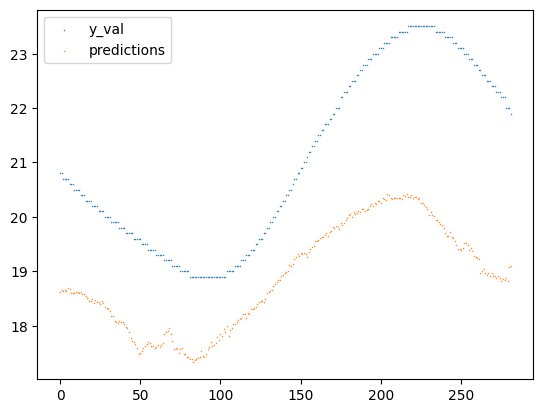

9/9 [==============================] - 0s 13ms/step


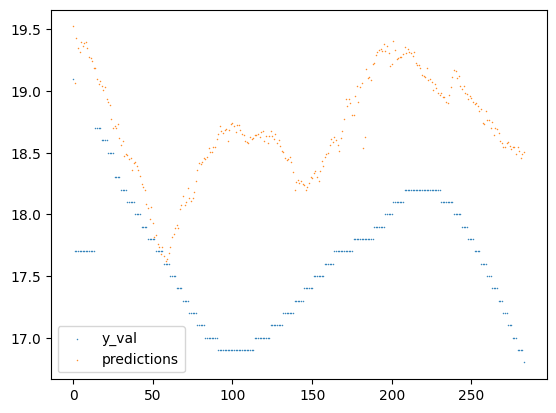

9/9 [==============================] - 0s 7ms/step


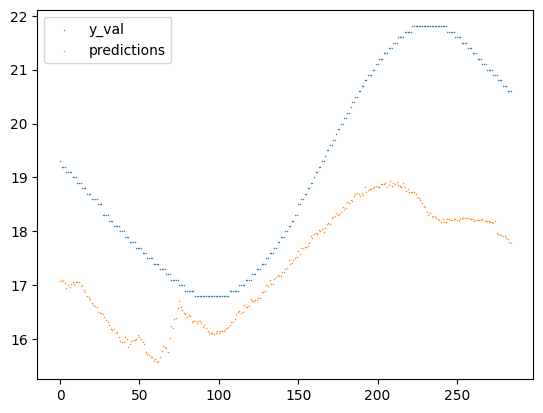

9/9 [==============================] - 0s 7ms/step


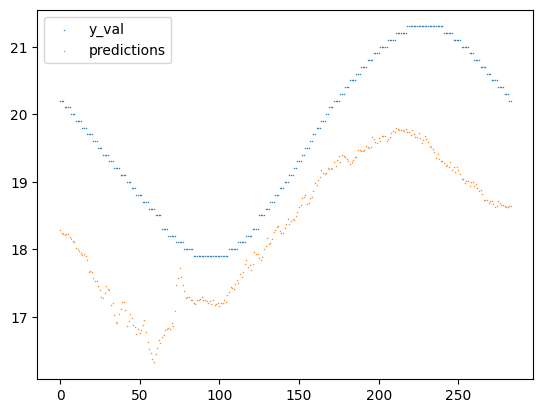

9/9 [==============================] - 0s 8ms/step


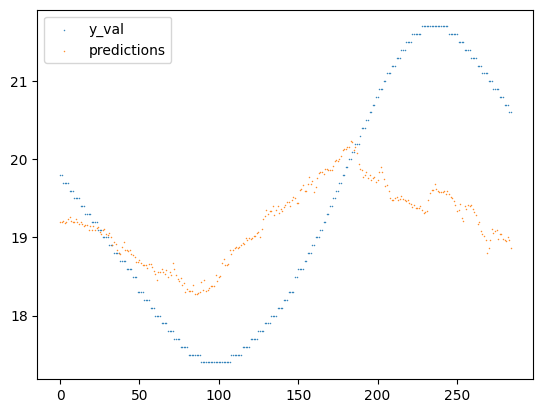

9/9 [==============================] - 0s 8ms/step


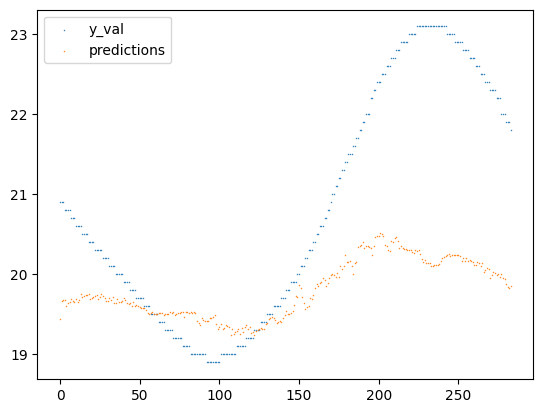

9/9 [==============================] - 0s 9ms/step


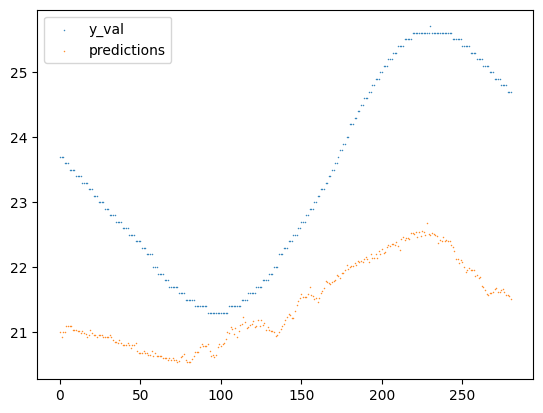

9/9 [==============================] - 0s 9ms/step


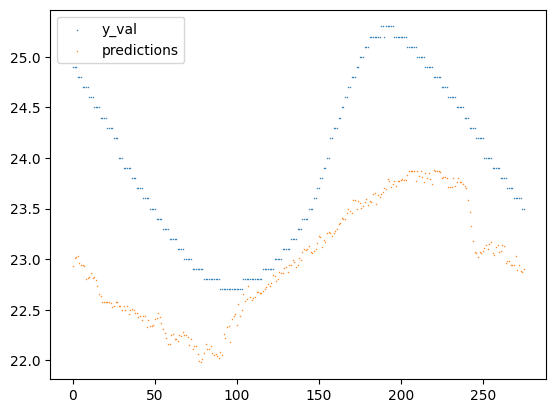

9/9 [==============================] - 0s 9ms/step


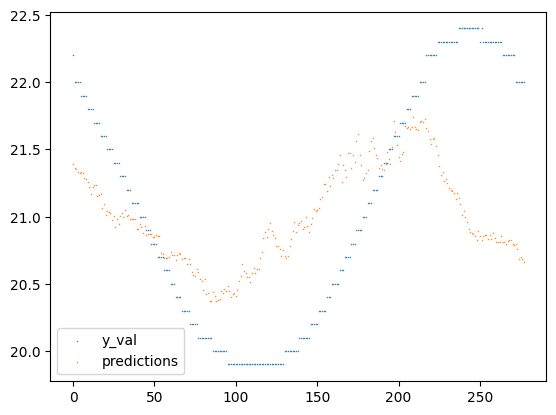

9/9 [==============================] - 0s 9ms/step


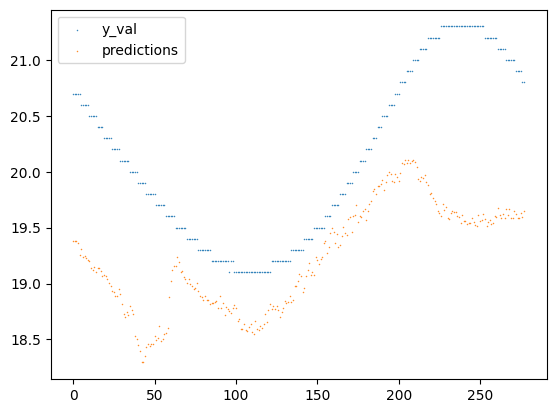

9/9 [==============================] - 0s 14ms/step


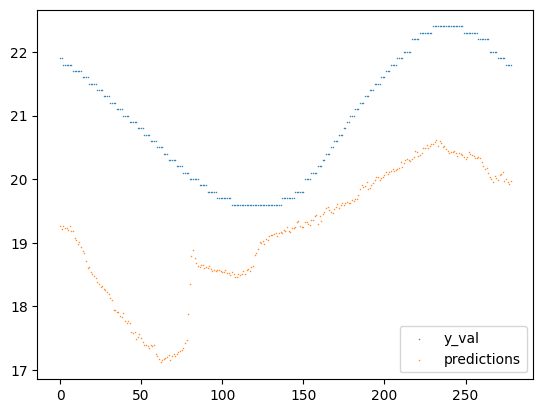

9/9 [==============================] - 0s 9ms/step


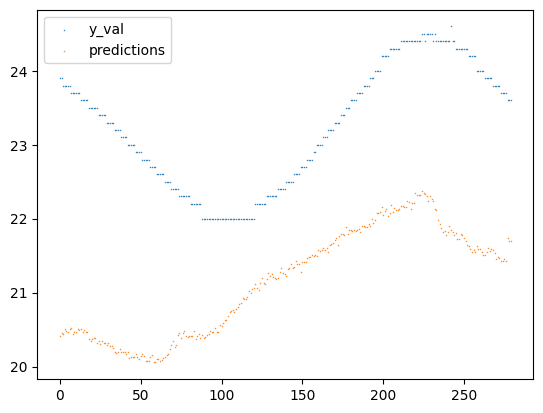

9/9 [==============================] - 0s 8ms/step


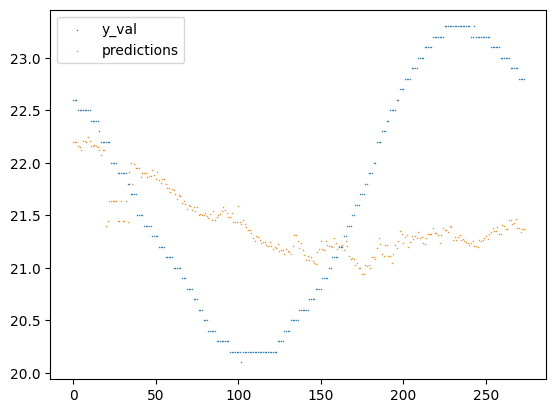

9/9 [==============================] - 0s 8ms/step


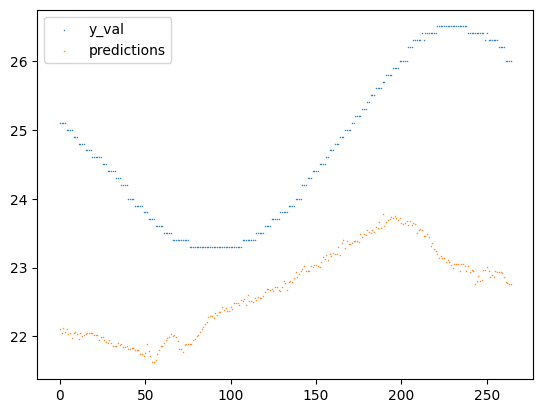

9/9 [==============================] - 0s 8ms/step


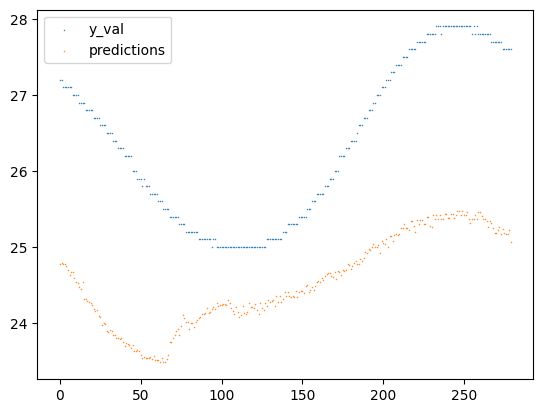

9/9 [==============================] - 0s 13ms/step


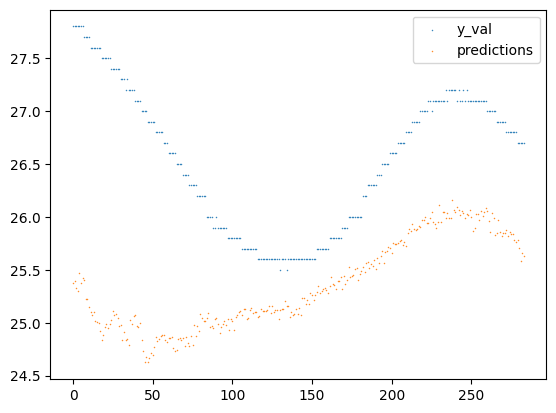

9/9 [==============================] - 0s 9ms/step


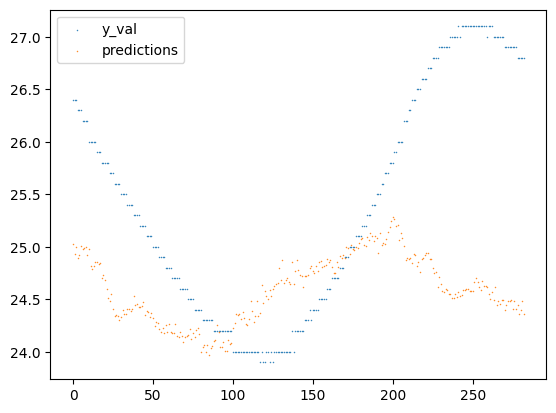

9/9 [==============================] - 0s 11ms/step


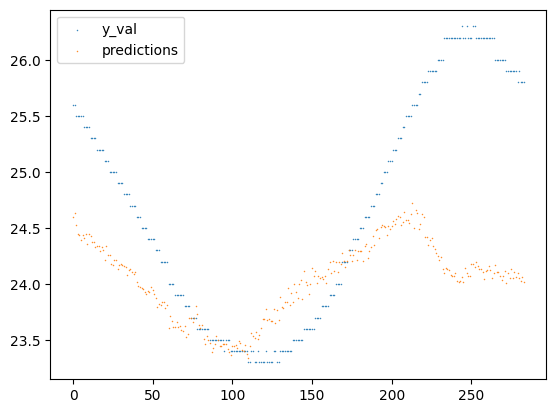

9/9 [==============================] - 0s 11ms/step


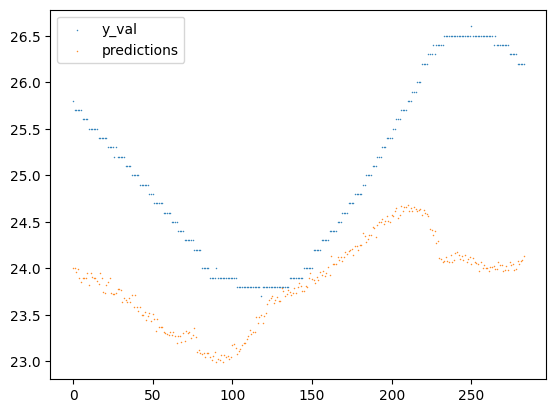

9/9 [==============================] - 0s 13ms/step


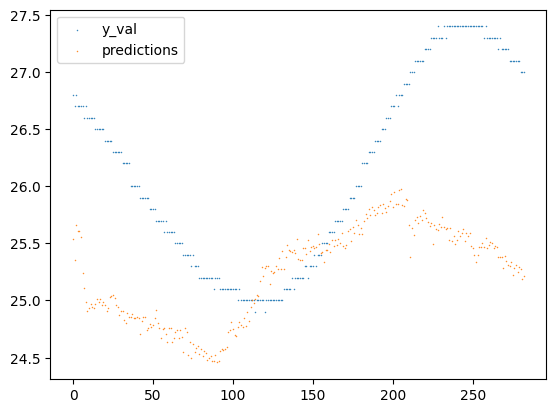

9/9 [==============================] - 0s 15ms/step


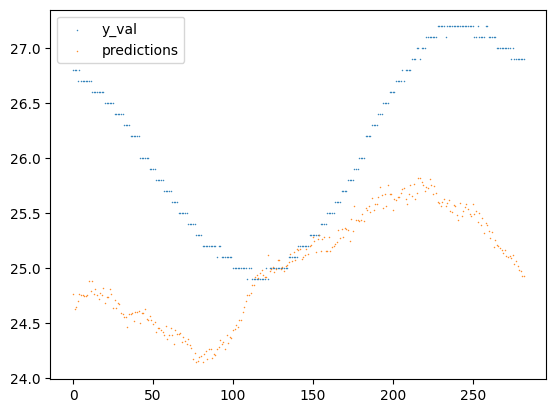

9/9 [==============================] - 0s 10ms/step


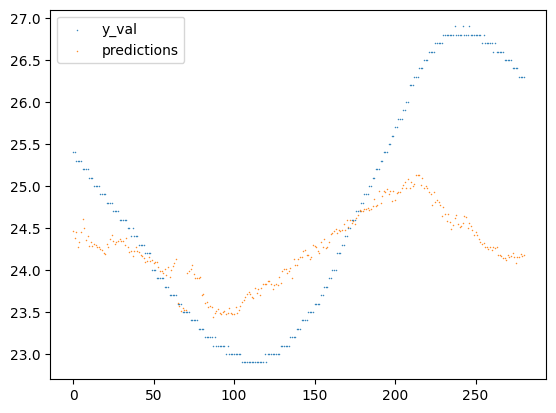

9/9 [==============================] - 0s 10ms/step


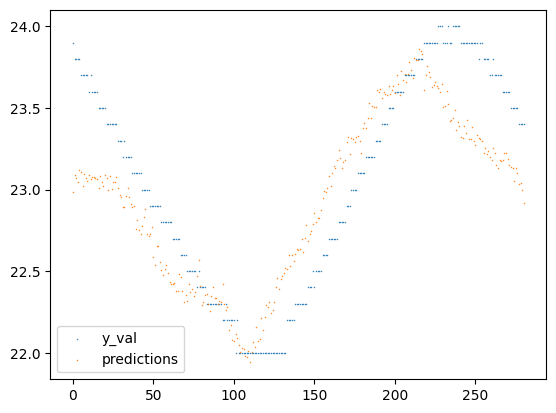

9/9 [==============================] - 0s 11ms/step


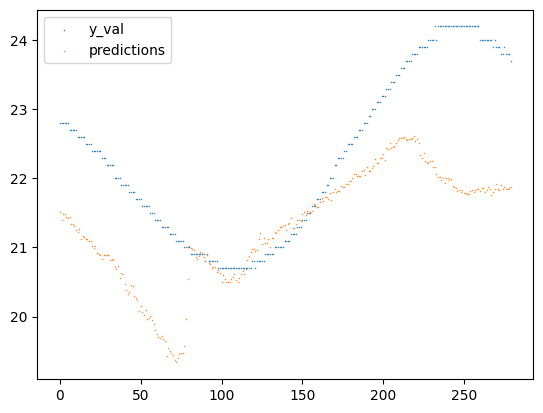

9/9 [==============================] - 0s 8ms/step


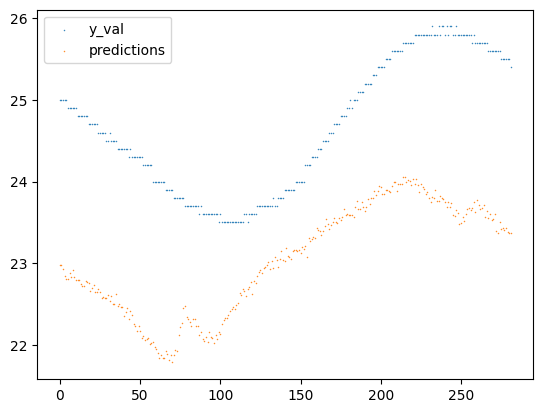

9/9 [==============================] - 0s 11ms/step


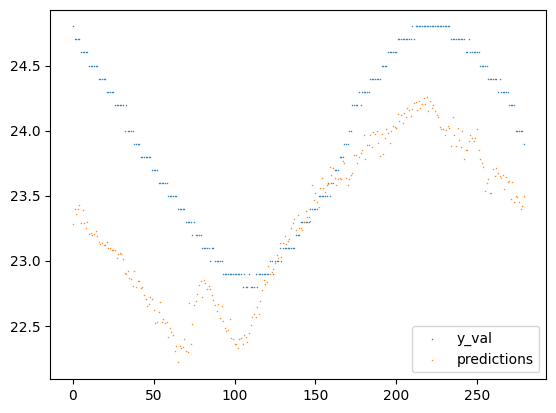

1/1 [==============================] - 0s 66ms/step


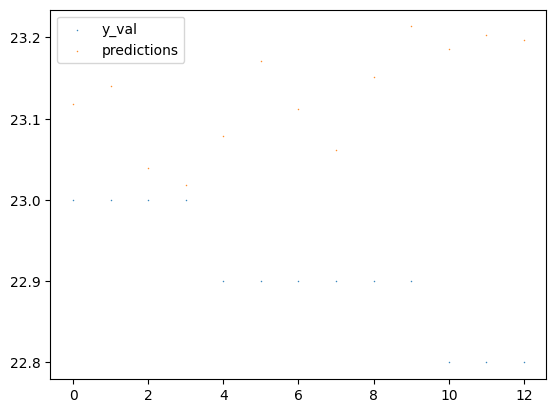

In [213]:
for val_input, val_target  in zip(val_data_input, val_data_target):

    predictions = pd.DataFrame(model.predict(val_input), columns=INPUT_COLS)

    predictions = denormalize(predictions)
    val_target = denormalize(val_target)
    
    plt.figure()
    plt.scatter(range(len(val_target["t_C_cal"])), val_target["t_C_cal"], linewidths=0.7, marker=".", s=0.5)
    plt.scatter(range(len(predictions["t_C_cal"])), predictions["t_C_cal"], linewidths=0.7, marker=".", s=0.5)
    plt.legend(["y_val", "predictions"])
    plt.show()

In [214]:
model.save("./ann_model", overwrite=True)

INFO:tensorflow:Assets written to: ./ann_model\assets


INFO:tensorflow:Assets written to: ./ann_model\assets
